### SIFT + Homography

In [17]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

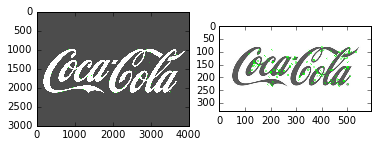

In [38]:
MIN_MATCH_COUNT = 10

imgRef = cv2.imread('./Data/Reference/1.jpg', 0) #1 is colour, 0 is greyscale, -1 is unchanged
imgTest = cv2.imread('./Data/Reference/2.jpg', 0)

# Initiate SIFT detector
sift = cv2.SIFT()

# find the keypoints and descriptors with SIFT
kpRef, desRef = sift.detectAndCompute(imgRef,None)
kpTest, desTest = sift.detectAndCompute(imgTest,None)

# draw only keypoints location,not size and orientation
imgRef_kp = cv2.drawKeypoints(imgRef,kpRef,color=(0,255,0), flags=0)
imgTest_kp = cv2.drawKeypoints(imgTest,kpTest,color=(0,255,0), flags=0)

fig = plt.figure()
plt.subplot(121)
plt.imshow(imgRef_kp)
plt.subplot(122)
plt.imshow(imgTest_kp)
plt.show()

In [55]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(desRef,desTest,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [74]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2); print(src_pts)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2); print(dst_pts)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = imgRef.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    imgTeest = cv2.polylines(imgTest,[np.int32(dst)],True,255,3, cv2.CV_AA)

else:
    print ("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

[[[  945.53491211   985.44464111]]

 [[  849.89373779   993.57672119]]

 [[ 3041.45727539   997.00689697]]

 [[ 2630.26757812  1000.38116455]]

 [[ 2864.25976562  1000.52819824]]

 [[ 3629.04858398  1000.45117188]]

 [[  819.56530762  1004.12805176]]

 [[  808.88580322  1005.00268555]]

 [[ 2616.15869141  1004.94812012]]

 [[ 2849.37280273  1004.96508789]]

 [[ 3069.46020508  1004.94226074]]

 [[ 2842.43945312  1007.37713623]]

 [[ 2708.62182617  1041.06933594]]

 [[  914.6350708   1044.56640625]]

 [[  899.09570312  1049.01049805]]

 [[ 2865.82519531  1055.99279785]]

 [[ 2836.99389648  1056.84143066]]

 [[ 2924.42651367  1066.57385254]]

 [[ 3611.93603516  1070.06164551]]

 [[ 3640.88769531  1103.08251953]]

 [[ 1015.07836914  1127.52868652]]

 [[ 2823.54785156  1145.6595459 ]]

 [[ 2779.42016602  1155.36877441]]

 [[ 3600.98974609  1155.60266113]]

 [[ 2820.11743164  1160.10351562]]

 [[ 2612.41748047  1161.34606934]]

 [[ 3623.8190918   1167.97229004]]

 [[ 3612.37768555  1174.1390

In [68]:
#for m in matchesMask:
#    print(m)

In [69]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

imgResult = cv2.drawMatches(imgRef,kpRef,imgRef,kpRef,good,None,**draw_params)

plt.imshow(imgResult, 'gray'),plt.show()

AttributeError: 'module' object has no attribute 'drawMatches'

## Alternative to draw matches

Ref: http://stackoverflow.com/questions/20259025/module-object-has-no-attribute-drawmatches-opencv-python

?? can only work with br.matches(), not knnMathces ??

In [23]:
import numpy as np
import cv2
%matplotlib inline

def drawMatches(img1, kp1, img2, kp2, matches):
    """
    My own implementation of cv2.drawMatches as OpenCV 2.4.9
    does not have this function available but it's supported in
    OpenCV 3.0.0

    This function takes in two images with their associated 
    keypoints, as well as a list of DMatch data structure (matches) 
    that contains which keypoints matched in which images.

    An image will be produced where a montage is shown with
    the first image followed by the second image beside it.

    Keypoints are delineated with circles, while lines are connected
    between matching keypoints.

    img1,img2 - Grayscale images
    kp1,kp2 - Detected list of keypoints through any of the OpenCV keypoint 
              detection algorithms
    matches - A list of matches of corresponding keypoints through any
              OpenCV keypoint matching algorithm
    """

    # Create a new output image that concatenates the two images together
    # (a.k.a) a montage
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')

    # Place the first image to the left
    out[:rows1,:cols1] = np.dstack([img1, img1, img1])

    # Place the next image to the right of it
    out[:rows2,cols1:] = np.dstack([img2, img2, img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:

        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns
        # y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt

        # Draw a small circle at both co-ordinates
        # radius 4
        # colour blue
        # thickness = 1
        cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)   
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)

        # Draw a line in between the two points
        # thickness = 1
        # colour blue
        cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (255, 0, 0), 1)


    # Show the image
    cv2.imshow('Matched Features', out)
    cv2.waitKey(0)
    cv2.destroyWindow('Matched Features')

    # Also return the image if you'd like a copy
    return out

## Alternative to drawMatches¶

In opencv2 has no cv2.drawMatches() module.

ref: https://gist.github.com/CannedYerins/11be0c50c4f78cad9549


In [24]:
def draw_matches(img1, kp1, img2, kp2, matches, color=None): 
    """Draws lines between matching keypoints of two images.  
    Keypoints not in a matching pair are not drawn.
    Places the images side by side in a new image and draws circles 
    around each keypoint, with line segments connecting matching pairs.
    You can tweak the r, thickness, and figsize values as needed.
    Args:
        img1: An openCV image ndarray in a grayscale or color format.
        kp1: A list of cv2.KeyPoint objects for img1.
        img2: An openCV image ndarray of the same format and with the same 
        element type as img1.
        kp2: A list of cv2.KeyPoint objects for img2.
        matches: A list of DMatch objects whose trainIdx attribute refers to 
        img1 keypoints and whose queryIdx attribute refers to img2 keypoints.
        color: The color of the circles and connecting lines drawn on the images.  
        A 3-tuple for color images, a scalar for grayscale images.  If None, these
        values are randomly generated.  
    """
    # We're drawing them side by side.  Get dimensions accordingly.
    # Handle both color and grayscale images.
    if len(img1.shape) == 3:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], img1.shape[2])
    elif len(img1.shape) == 2:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1])
    new_img = np.zeros(new_shape, type(img1.flat[0]))  
    # Place images onto the new image.
    new_img[0:img1.shape[0],0:img1.shape[1]] = img1
    new_img[0:img2.shape[0],img1.shape[1]:img1.shape[1]+img2.shape[1]] = img2
    
    # Draw lines between matches.  Make sure to offset kp coords in second image appropriately.
    r = 15
    thickness = 2
    if color:
        c = color
    for m in matches:
        # Generate random color for RGB/BGR and grayscale images as needed.
        if not color: 
            c = np.random.randint(0,256,3) if len(img1.shape) == 3 else np.random.randint(0,256)
        # So the keypoint locs are stored as a tuple of floats.  cv2.line(), like most other things,
        # wants locs as a tuple of ints.
        end1 = tuple(np.round(kp1[m.trainIdx].pt).astype(int))
        end2 = tuple(np.round(kp2[m.queryIdx].pt).astype(int) + np.array([img1.shape[1], 0]))
        cv2.line(new_img, end1, end2, c, thickness)
        cv2.circle(new_img, end1, r, c, thickness)
        cv2.circle(new_img, end2, r, c, thickness)
    
    plt.figure(figsize=(15,15))
    plt.imshow(new_img)
    plt.show()

## Another alternative to draw matches

In [49]:
from find_obj import filter_matches,explore_match
pRef, pTest, kp_pairs = filter_matches(kpRef, kpTest, matchesMask)
explore_match('find_obj', imgRef,imgTest,kp_pairs)#cv2 shows image

cv2.waitKey()
cv2.destroyAllWindows()

ImportError: No module named find_obj